In [1]:
##
## AlexNet analog (Krizhevsky 2012)
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-06
##  общая оценка не дает выше fpred на train 0.81-0.84
##  Поэтому проверяется идея раздельного подсчета для признаков (пачками), например 0-4, 5-9, 10-14, 15-16. 
##  Полученные результаты будут склеены и обработаны для результата.
##  Предварительная оценка fpred = 0.9 на подмножестве 0-4, существенное улучшение попаданий для набора 64x64x6.
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
#del(trOX); del(trOY);

In [15]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [16]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if True :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY-tif.npy')
    print(trX.shape,trY.shape)

(40479, 64, 64, 6) (40479, 17)


In [17]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 64, 64, 6) (40479, 17)


In [18]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [19]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012 ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012X ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    #model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(Convolution2D(128,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    #model.add(Dense(4096,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Dense(4096,activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [20]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012x3x3 ( model, iSize, rSize, cv2d, dense, pp ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(axis=3,input_shape=(i1,i2,i3)))
    
    if not (cv2d is None) :
        for cv in cv2d :
            if (cv>0) :
                model.add(Convolution2D(cv,(2,2)))
                #model.add(BatchNormalization(axis=3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.25))

    model.add(Flatten())
    
    if not (dense is None) :
        for de in dense :
            if (de>0) :
                model.add(Dense(pp[5],activation='relu'))
                model.add(Dropout(0.5))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [21]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    model = Kriz2012(model,iSize,rSize)
    
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    
    #model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
    #              optimizer="sgd", #sgd, #"adam", #'rmsprop',
    #              metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [84]:
##trY = trY[:,0:4]
iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], []
print(iSize,rSize)
metric = 'acc'
model10 = buildModelKriz(iSize,rSize)

(64, 64, 6) 17


In [85]:
if False :
    sgd = keras.optimizers.SGD(nesterov=True)
    model10.compile(loss= 'binary_crossentropy', 
                #'mean_squared_error', #'mean_absolute_error',  #'binary_crossentropy','categorical_crossentropy',
                  optimizer="rmsprop", #sgd, #"adam", #'rmsprop',
                  metrics=[metric,fbeta_pred]) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [86]:
if False : model10.load_weights('../Data-Keras/Models/model-Alex-weights-128x128x3.h5', by_name=False)

In [87]:
#
# Общие параметры
#
epochs     = 10
verbose    = 2
batch_size = 64
stopping   = 3

prefixTemp = 'tif-64x64x6'     
metric = 'acc'


early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001)

In [103]:
#
# Первичное построение, тренировка и сохрание моделей по признакам в цикле
#

epochs     = 10

##for fs in [range(0,5),range(5,11),range(11,17)] :
##for fs in [range(5,8),range(8,9),range(9,11),range(11,17)] :
##for fs in [range(5,8)] :
#for fs in [range(8,9)] :
for fs in [range(4,5),range(5,6),range(6,7),range(7,8),range(8,9),range(9,10),range(10,11)] :
    print(fs)
    trYY = trY[:,fs]
    iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trYY.shape[1], []
    print(iSize,rSize)
    model10 = buildModelKriz(iSize,rSize)
    #filepath="../Temp/Temp/"+prefixTemp+"-fs-"+str(fs[0])+".{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-val_fbeta_pred={val_fbeta_pred:.4f}.hdf5"
    filepath="../Temp/Temp/"+prefixTemp+"-fs-"+str(fs[0])+"-ep={epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}.hdf5"
    ##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
    checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

    hist1  = model10.fit(trX,trYY,
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=0.10, 
                        callbacks=[early_stopping,checkpoint], #,reduce_lr],
                        verbose=verbose)
    if True : #False :
        save_model(model10,'../Data-Keras/Models/AlexTIFLoop/model-Alex-fs='+str(fs[0])+'-64x64x6-tif.h5')
        model10.save_weights('../Data-Keras/Models/AlexTIFLoop/model-Alex-weights-fs='+str(fs[0])+'-64x64x6-tif.h5')
    print(datetime.datetime.now(), fs[0])


print(datetime.datetime.now())

[2]
(64, 64, 6) 1
Train on 36431 samples, validate on 4048 samples
Epoch 1/10
Epoch 00000: acc improved from -inf to 0.74039, saving model to ../Temp/Temp/tif-64x64x6-fs-2-ep=00-acc=0.7404-val_acc=0.7342.hdf5
48s - loss: 0.5034 - acc: 0.7404 - val_loss: 0.5585 - val_acc: 0.7342
Epoch 2/10
Epoch 00001: acc improved from 0.74039 to 0.79734, saving model to ../Temp/Temp/tif-64x64x6-fs-2-ep=01-acc=0.7973-val_acc=0.8061.hdf5
48s - loss: 0.4397 - acc: 0.7973 - val_loss: 0.4239 - val_acc: 0.8061
Epoch 3/10
Epoch 00002: acc improved from 0.79734 to 0.81271, saving model to ../Temp/Temp/tif-64x64x6-fs-2-ep=02-acc=0.8127-val_acc=0.8219.hdf5
47s - loss: 0.4180 - acc: 0.8127 - val_loss: 0.4098 - val_acc: 0.8219
Epoch 4/10
Epoch 00003: acc improved from 0.81271 to 0.81892, saving model to ../Temp/Temp/tif-64x64x6-fs-2-ep=03-acc=0.8189-val_acc=0.6549.hdf5
47s - loss: 0.4073 - acc: 0.8189 - val_loss: 0.7160 - val_acc: 0.6549
Epoch 5/10
Epoch 00004: acc improved from 0.81892 to 0.82391, saving model t

In [94]:
trYY.shape

(40479, 1)

In [95]:
trX.shape, trY.shape, trYY.shape

((40479, 64, 64, 6), (40479, 17), (40479, 1))

In [96]:
%time trP = model10.predict(trX, batch_size=128) #batch_size)

CPU times: user 9.14 s, sys: 2.94 s, total: 12.1 s
Wall time: 18.5 s


In [97]:
print(model10.evaluate(trX,trYY,verbose=2))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trYY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_pred =',K.get_value(fbeta_pred(trYY.astype(np.float64),trP.astype(np.float64))))

[0.12356640940523392, 0.94673781464724749]
(40479, 17)
(40479, 1)


In [36]:
def buildResult( trX, modelFileNames, debugOK=False ) :
    i, tResult = 0, np.zeros((trX.shape[0],len(modelFileNames)))
    if debugOK : print(tResult.shape)
    for mf in modelFileNames :
        #model11  = Sequential();
        model11  = load_model(mf);
        tPredict = model11.predict(trX)
        if debugOK : print(i,tPredict.shape,tPredict[0:2].tolist())
        tResult[:,i] = tPredict[:,0]; i+=1;
        del model11
    return(tResult)

In [37]:
modelFiles = ['../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=0-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=1-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=2-64x64x6-tif.h5',
              '../Data-Keras/Models/AlexTIFLoop/model-Alex-fs=3-64x64x6-tif.h5',
             ]

In [38]:
trPr = buildResult(trX,modelFiles,debugOK=True)

(40479, 4)
0 (40479, 1) [[0.4673333168029785], [3.843682134174742e-05]]
1 (40479, 1) [[0.9913997650146484], [0.9999233484268188]]
2 (40479, 1) [[0.02008485235273838], [0.9693036675453186]]
3 (40479, 1) [[0.48368996381759644], [0.8902558088302612]]


In [48]:
getProb01(trPr[0:15]),trY[0:15,0:4]
#del model10

(array([[ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  0.,  1.],
        [ 0.,  1.,  0.,  1.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  0.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  1.,  0.,  1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.]]), array([[1, 1, 0, 0],
        [0, 1, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 0, 1],
        [0, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 0, 1],
        [0, 0, 0, 0],
        [0, 1, 0, 1],
        [0, 0, 0, 0]]))

In [60]:
if True : #False :
    save_model(model10,'../Data-Keras/Models/model-Alex-64x64x6-tif.h5')
    model10.save_weights('../Data-Keras/Models/model-Alex-weights-64x64x6-tif.h5')

In [98]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 14, 14, 96)        69792     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 10, 10, 256)       614656    
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 4, 4, 256)         884992    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 2, 2, 256)         0         
__________

In [100]:
trP[0:5], trY[0:5]

(array([[ 0.99139977],
        [ 0.99992335],
        [ 0.99998081],
        [ 0.99983466],
        [ 0.99891794]], dtype=float32),
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [41]:
# Процедуры для оценки результативности

def confusion_matrix (tTruth, tPredict) :
    tp  = (tTruth==tPredict)&(tTruth==1); tp=len(tp[tp])
    fn  = (tTruth==tPredict)&(tTruth==0); fn=len(fn[fn])
    tn  = (tTruth<>tPredict)&(tTruth==1); tn=len(tn[tn])
    fp  = (tTruth<>tPredict)&(tTruth==0); fp=len(fp[fp])
    return(np.array([[tp,tn],[fp,fn]]))

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        #cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
        cList.append(confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [42]:
print(confusion_matrix(np.array([0,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,1])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([0,1])).tolist()
      )

[[0, 0], [1, 1]] [[1, 1], [0, 0]] [[2, 0], [0, 0]] [[1, 0], [0, 1]] [[0, 1], [1, 0]]


In [43]:
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

In [44]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)
##ixx, iacc = getTh(trY,trP, prec=100)
#np.array(ixx) , iacc

In [101]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trYY,trP)
np.array(ixx), iacc

(array([ 0.41]),
 [(41.0, 0.94844240223325671, 0.94673781466933471, 2087, 2156)])

In [69]:
fresList=[]

In [45]:
#
# Оценка результативности предсказания
#
# Выдача массива:
#   номер поля
#   accuracy
#   roc_auc
#   tt, nn        <-- должно быть
#   tp,fn,(fp+tn) <-- получили
#
#
def estimateResult (tThruth, tPredict) :
    res = [];
    for i in range(tThruth.shape[1]) :
        cm = confusion_matrix(tThruth[:,i],tPredict[:,i])
        print('{} acc={} roc={} not={} yes={} no={} true={} all-1-0=({:.4f}-{:.4f})'.format(i,
                  skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                  skm.roc_auc_score(tThruth[:,i],tPredict[:,i]),
                  cm[0,1]+cm[1,0],
                  cm[0,0],cm[1,1],
                  cm[0,0]+cm[1,1],
                  float(cm[0,0])/len(tThruth[tThruth[:,i]==1,i]),
                  float(cm[1,1])/len(tThruth[tThruth[:,i]==0,i]),
                 ));
        res.append ((i,tThruth.shape[0],
                    skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                    #skm.accuracy_score(tThruth[:,i],tPredict[:,i]),
                    skm.roc_auc_score(tThruth[:,i],tPredict[:,i]),
                    len(tThruth[tThruth[:,i]==1]), len(tThruth[tThruth[:,i]==0]),
                    cm[0,0], cm[1,1],cm[0,1]+cm[1,0]))
    return(np.array(res))

In [54]:
print(trY.shape)
#fres = estimateResult(trYY,getProb01(trP))
fres = estimateResult(trY[:,0:4],getProb01(trPr))
#fresList.append(fres)
fres.tolist()

(40479, 17)
0 acc=0.940685293609 roc=0.634240331027 not=2401 yes=757 no=37321 true=38078 all-1-0=(0.2807-0.9878)
1 acc=0.946737814669 roc=0.818654024168 not=2156 yes=36340 no=1983 true=38323 all-1-0=(0.9687-0.6686)
2 acc=0.84932928185 roc=0.812670320055 not=6099 yes=8855 no=25525 true=34380 all-1-0=(0.7190-0.9063)
3 acc=0.859680328071 roc=0.784364178823 not=5680 yes=27591 no=7208 true=34799 all-1-0=(0.9705-0.5983)


[[0.0,
  40479.0,
  0.9406852936090319,
  0.6342403310273227,
  2697.0,
  37782.0,
  757.0,
  37321.0,
  2401.0],
 [1.0,
  40479.0,
  0.9467378146693347,
  0.8186540241684523,
  37513.0,
  2966.0,
  36340.0,
  1983.0,
  2156.0],
 [2.0,
  40479.0,
  0.849329281849848,
  0.8126703200550941,
  12315.0,
  28164.0,
  8855.0,
  25525.0,
  6099.0],
 [3.0,
  40479.0,
  0.8596803280713456,
  0.7843641788233792,
  28431.0,
  12048.0,
  27591.0,
  7208.0,
  5680.0]]

In [67]:
38951.0/40479

0.9622520319177845

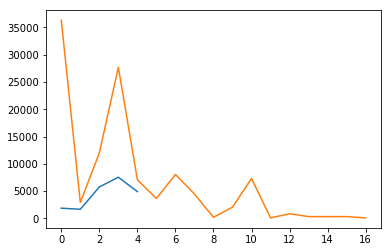

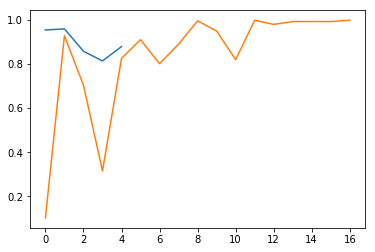

In [137]:
plt.plot([x[4] for x in fresList[-1]]); 
plt.plot([x[4] for x in fresList[-2]]); 
plt.show()
plt.plot([x[2] for x in fresList[-1]]); 
plt.plot([x[2] for x in fresList[-2]]); 
plt.show()

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
